# Computer Vision II Final Assigment

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import argparse
from dataloader import show_samples
from PIL import Image
import random
from torch import nn
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import torch
import torch.optim as optim

In [72]:
dataPath = 'dataset'  

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor()])

dataset_train = datasets.ImageFolder(root=f'{dataPath}/train', transform=transform)
dataset_valid = datasets.ImageFolder(root=f'{dataPath}/valid', transform=transform)
dataset_test = datasets.ImageFolder(root=f'{dataPath}/test', transform=transform)

In [76]:
query_image_path = './dataset/test/007/image_07201.jpg'
query_image= Image.open(query_image_path)
query_label = "007"


Train: Dataset ImageFolder
    Number of datapoints: 1071
    Root location: dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )
 Validation: Dataset ImageFolder
    Number of datapoints: 135
    Root location: dataset/valid
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )
 Test: Dataset ImageFolder
    Number of datapoints: 56
    Root location: dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

Labels: ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012'

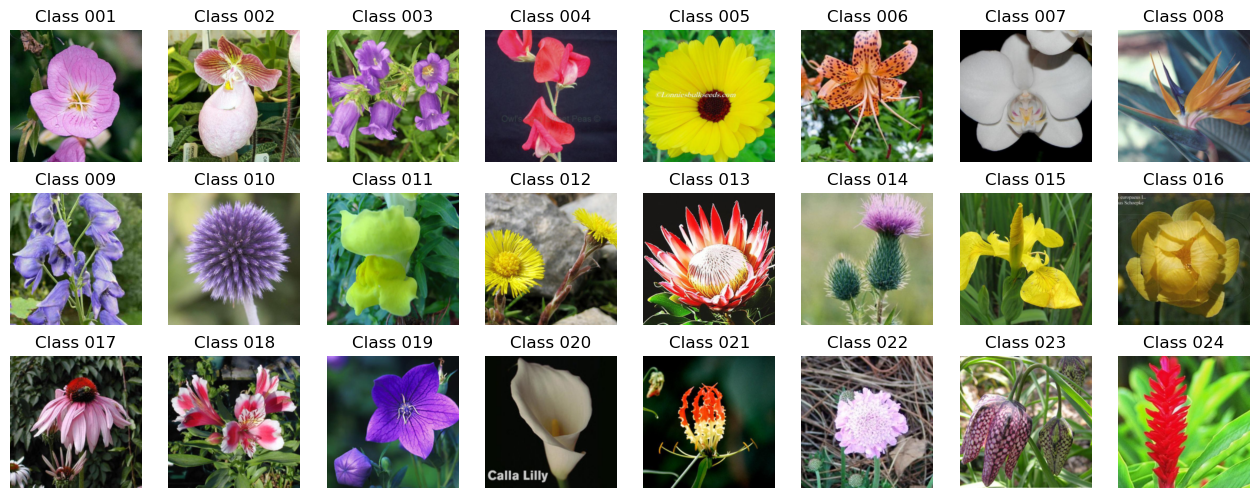

In [17]:
print(f'Train: {dataset_train}\n', f'Validation: {dataset_valid}\n', f'Test: {dataset_test}\n')
print(f"Labels: {dataset_train.classes}")
show_samples(dataset_train)

### Task 1

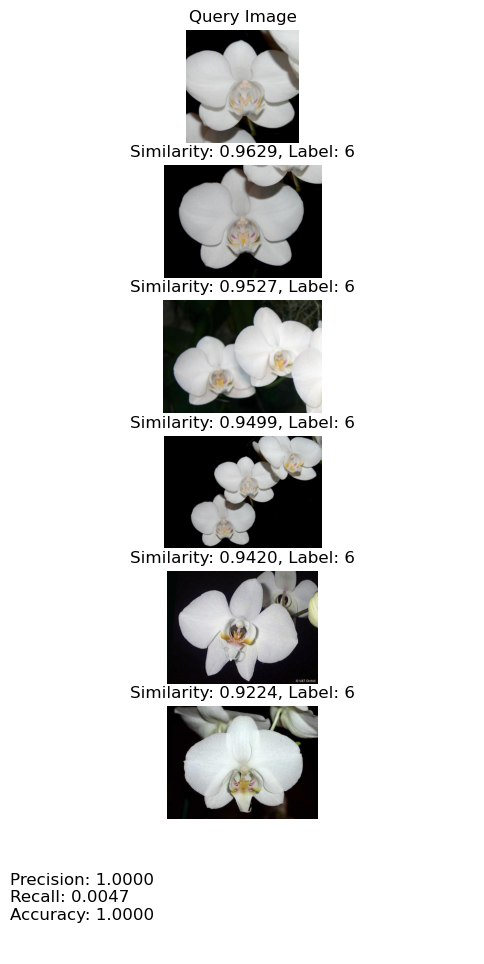

In [77]:
# Load the pretrained VGG-11 model
model = models.vgg11(pretrained=True)
model.eval()

dataset = dataset_train

# Compute embeddings
with torch.no_grad():
    query_image = transform(query_image)
    query_embedding = model(query_image.unsqueeze(0))
    reference_embeddings = []
    for i in range(len(dataset)):
        image, _ = dataset[i]
        embedding = model(image.unsqueeze(0))
        reference_embeddings.append(embedding)

# Compute similarity metric
similarity_scores = []
for embedding in reference_embeddings:
    similarity = F.cosine_similarity(query_embedding, embedding)
    similarity_scores.append(similarity.item())

# Rank the k most similar images
k = 5  # Choose the desired number of most similar images
most_similar_indices = sorted(range(len(similarity_scores)), key=lambda i: similarity_scores[i], reverse=True)[:k]

# Compute performance metrics
query_label = dataset.class_to_idx[query_label]
ground_truth_labels = [dataset.imgs[i][1] for i in most_similar_indices]  # Ground truth labels for the most similar images

# Calculate precision
precision = sum(label == query_label for label in ground_truth_labels) / k

# Calculate recall
relevant_images = sum(label == query_label for label in ground_truth_labels)
recall = relevant_images / len(dataset)

# Calculate accuracy
accuracy = sum(label == query_label for label in ground_truth_labels) / len(ground_truth_labels)

# Print or visualize the results
fig, axs = plt.subplots(k+2, 1, figsize=(6, 12))

# Display query image
query_image = query_image.permute(1, 2, 0)
axs[0].imshow(query_image)
axs[0].axis('off')
axs[0].set_title("Query Image")

# Display most similar images
for i, index in enumerate(most_similar_indices):
    image_path, label = dataset.imgs[index]
    image = Image.open(image_path)
    axs[i+1].imshow(image)
    axs[i+1].axis('off')
    axs[i+1].set_title(f"Similarity: {similarity_scores[index]:.4f}, Label: {label}")

# Display performance metrics
axs[k+1].axis('off')
axs[k+1].text(0, 0.5, f"Precision: {precision:.4f}\nRecall: {recall:.4f}\nAccuracy: {accuracy:.4f}",
              fontsize=12, verticalalignment='center')

plt.show()

### Task 2

In [80]:
# Define the CNN architecture
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.features = models.vgg11(pretrained=True).features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 128)  # Embedding size

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [81]:
from torchvision.datasets import DatasetFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam


# Define the contrastive loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, embeddings1, embeddings2, labels):
        distances = nn.functional.pairwise_distance(embeddings1, embeddings2)
        loss = torch.mean((1 - labels) * torch.pow(distances, 2) +
                          (labels) * torch.pow(torch.clamp(self.margin - distances, min=0.0), 2))
        return loss

# Set random seed for reproducibility
torch.manual_seed(42)

dataset = dataset_train

# Define data loader
batch_size = 258
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model and loss function
model = CustomCNN()
loss_fn = ContrastiveLoss()

# Define optimizer and learning rate scheduler
optimizer = Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_images, batch_labels in dataloader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Handle odd number of images in the batch
        if batch_images.shape[0] % 2 != 0:
            batch_images = batch_images[:-1]
            batch_labels = batch_labels[:-1]

        # Forward pass
        embeddings = model(batch_images)
        embeddings1, embeddings2 = torch.chunk(embeddings, 2, dim=0)

        # Generate labels for image pairs (0 for similar, 1 for dissimilar)
        labels = (batch_labels[::2] == batch_labels[1::2]).float()

        # Compute loss and update parameters
        optimizer.zero_grad()
        loss = loss_fn(embeddings1, embeddings2, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    # Print epoch loss
    average_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "trained_model.pth")

Epoch [1/20], Loss: 150171715.7412
Epoch [2/20], Loss: 158656.3352
Epoch [3/20], Loss: 39624.3965
Epoch [4/20], Loss: 18455.6631
Epoch [5/20], Loss: 8220.1283
Epoch [6/20], Loss: 1840.8710


In [57]:
# Load the trained model
model = CustomCNN()
model.load_state_dict(torch.load("trained_model.pth"))
model.eval()

CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [58]:
from torch.utils.data import DataLoader
dataset = dataset_train
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [65]:
query_image_path = './dataset/test/007/image_07201.jpg'
query_image= Image.open(query_image_path)

query_label = "007"

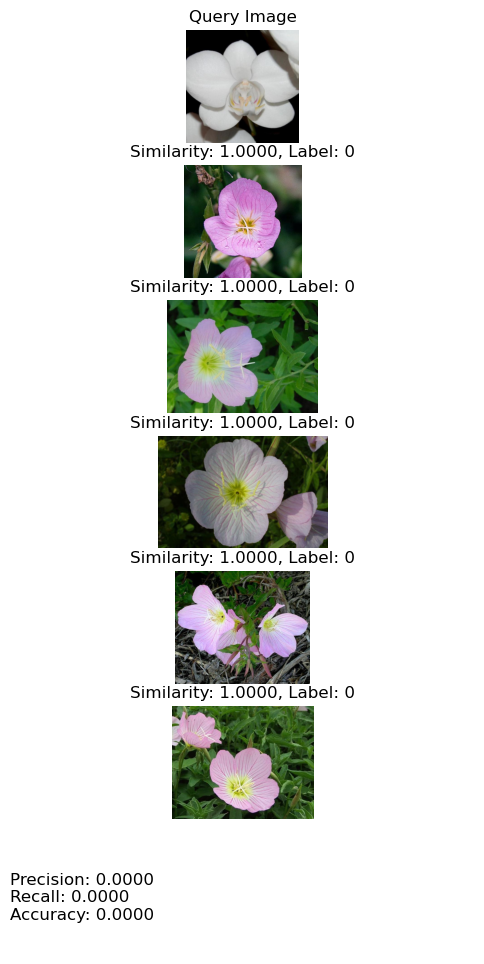

In [66]:

# Compute embeddings
with torch.no_grad():
    query_image = transform(query_image)
    query_embedding = model(query_image.unsqueeze(0))
    reference_embeddings = []
    for i in range(len(dataset)):
        image, _ = dataset[i]
        embedding = model(image.unsqueeze(0))
        reference_embeddings.append(embedding)

# Compute similarity metric
similarity_scores = []
for embedding in reference_embeddings:
    similarity = F.cosine_similarity(query_embedding, embedding)
    similarity_scores.append(similarity.item())

# Rank the k most similar images
k = 5  # Choose the desired number of most similar images
most_similar_indices = sorted(range(len(similarity_scores)), key=lambda i: similarity_scores[i], reverse=True)[:k]

# Compute performance metrics
query_label = dataset.class_to_idx[query_label]
ground_truth_labels = [dataset.imgs[i][1] for i in most_similar_indices]  # Ground truth labels for the most similar images

# Calculate precision
precision = sum(label == query_label for label in ground_truth_labels) / k

# Calculate recall
relevant_images = sum(label == query_label for label in ground_truth_labels)
recall = relevant_images / len(dataset)

# Calculate accuracy
accuracy = sum(label == query_label for label in ground_truth_labels) / len(ground_truth_labels)

# Print or visualize the results
fig, axs = plt.subplots(k+2, 1, figsize=(6, 12))

# Display query image
query_image = query_image.permute(1, 2, 0)
axs[0].imshow(query_image)
axs[0].axis('off')
axs[0].set_title("Query Image")

# Display most similar images
for i, index in enumerate(most_similar_indices):
    image_path, label = dataset.imgs[index]
    image = Image.open(image_path)
    axs[i+1].imshow(image)
    axs[i+1].axis('off')
    axs[i+1].set_title(f"Similarity: {similarity_scores[index]:.4f}, Label: {label}")

# Display performance metrics
axs[k+1].axis('off')
axs[k+1].text(0, 0.5, f"Precision: {precision:.4f}\nRecall: {recall:.4f}\nAccuracy: {accuracy:.4f}",
              fontsize=12, verticalalignment='center')

plt.show()

### Pairs

c:\Users\corre\anaconda3\envs\theone\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\corre\anaconda3\envs\theone\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


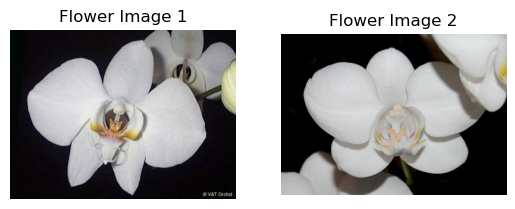

The similarity score between the flower images is: 0.9003
The flowers are from the same species.


In [70]:
# Load the pretrained VGG-11 model
model = models.vgg11(pretrained=True)
model.eval()

# Define the two flower images
flower_image1 = Image.open("./dataset/train/007/image_07209.jpg")
flower_image2 = Image.open("./dataset/test/007/image_07201.jpg")

# Preprocess the flower images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
flower_tensor1 = transform(flower_image1).unsqueeze(0)
flower_tensor2 = transform(flower_image2).unsqueeze(0)

# Compute embeddings
with torch.no_grad():
    flower_embedding1 = model(flower_tensor1)
    flower_embedding2 = model(flower_tensor2)

# Compute similarity score
similarity = F.cosine_similarity(flower_embedding1, flower_embedding2)
threshold = 0.9  # Set the threshold for similarity score

# Print the flower images
plt.subplot(1, 2, 1)
plt.imshow(flower_image1)
plt.title("Flower Image 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(flower_image2)
plt.title("Flower Image 2")
plt.axis("off")

plt.show()

# Print the similarity score
print(f"The similarity score between the flower images is: {similarity.item():.4f}")

# Determine if the flowers are from the same species
if similarity.item() > threshold:
    print("The flowers are from the same species.")
else:
    print("The flowers are from different species.")

c:\Users\corre\anaconda3\envs\theone\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\corre\anaconda3\envs\theone\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


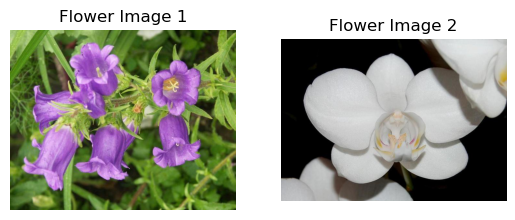

The similarity score between the flower images is: 1.0000
The flowers are from the same species.


In [79]:
# Load the pretrained VGG-11 model
# Load the trained model
model = CustomCNN()
model.load_state_dict(torch.load("trained_model.pth"))
model.eval()

# Define the two flower images
flower_image1 = Image.open("./dataset/train/003/image_06612.jpg")
flower_image2 = Image.open("./dataset/test/007/image_07201.jpg")

# Preprocess the flower images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
flower_tensor1 = transform(flower_image1).unsqueeze(0)
flower_tensor2 = transform(flower_image2).unsqueeze(0)

# Compute embeddings
with torch.no_grad():
    flower_embedding1 = model(flower_tensor1)
    flower_embedding2 = model(flower_tensor2)

# Compute similarity score
similarity = F.cosine_similarity(flower_embedding1, flower_embedding2)
threshold = 0.9  # Set the threshold for similarity score

# Print the flower images
plt.subplot(1, 2, 1)
plt.imshow(flower_image1)
plt.title("Flower Image 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(flower_image2)
plt.title("Flower Image 2")
plt.axis("off")

plt.show()

# Print the similarity score
print(f"The similarity score between the flower images is: {similarity.item():.4f}")

# Determine if the flowers are from the same species
if similarity.item() > threshold:
    print("The flowers are from the same species.")
else:
    print("The flowers are from different species.")